<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/LSTM%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 37.4MB/s]
  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 72.2MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [281]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [282]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

In [283]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

In [284]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

## EDA

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0




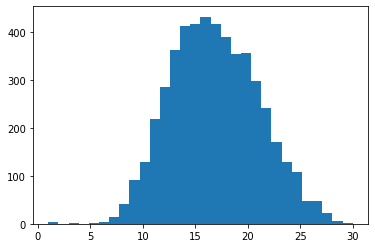

In [285]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [286]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [287]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF
    
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [288]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [289]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [290]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


In [291]:
# 단어수 
print(len(set([word for words in train_tweet for word in words.split()])))

8517


 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 21
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1706
 tweet 의 길이의 중간값 : 10.0




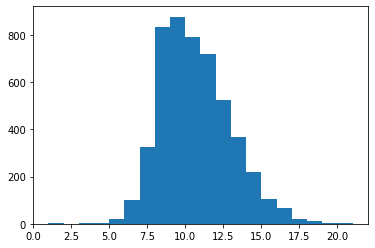

In [292]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

In [293]:
np.quantile(word_count, 0.025)

6.0

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 20
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1968
 tweet 의 길이의 중간값 : 10.0




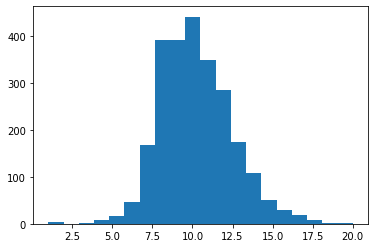

In [294]:
word_count = test_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

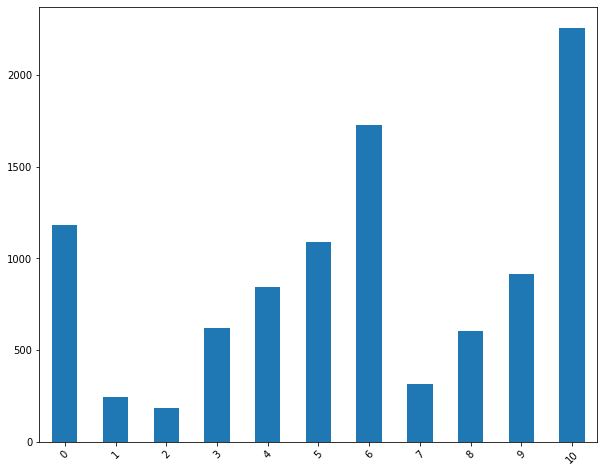

In [317]:
train_df_sentiment = train_df[cols_target]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_df_sentiment.sum(axis=0).plot.bar()
plt.xticks(rotation = 45)
plt.show()

## 토큰화 및 패딩

In [295]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [296]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [297]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [298]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [299]:
word_vocab = tokenizer.word_index
#print(word_vocab)

In [300]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [301]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [302]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


## 벡터화


### SENTENCEPIECE

In [ ]:
!pip install sentencepiece
import sentencepiece as spm

     |████████████████████████████████| 1.2MB 12.6MB/s 


In [ ]:
train_tweet.shape

(5000,)

In [ ]:
with open('./full_tweet.txt', 'w', encoding='utf-8') as f:
    for line in train_tweet :
        if len(str(line).strip()) == 0 : continue
        try : 
            f.write(line + '\n')
        except : continue

In [ ]:
!cat full_tweet.txt | head -n2

joke hop plane rn well covid lol
banmediahouse whose responsible spreading fake communal story pandemic covid situation


In [ ]:
spm.SentencePieceTrainer.train('--input=full_tweet.txt --model_prefix=m --vocab_size=5000')

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [ ]:
train_df['bow'] = train_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))
test_df['bow'] = test_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))

In [ ]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."


In [ ]:
test_df.head(2)

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."


In [ ]:
train_pad = pad_sequences(train_df['bow'].values, maxlen=22)
test_pad = pad_sequences(test_df['bow'].values, maxlen=22)

## 여기부터 볼 것

In [322]:
x = train_df.Tweet.values.tolist()
y = train_df_sentiment.values

In [325]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state =42)
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 30

x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

In [326]:
#glove

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-06-07 05:41:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-07 05:41:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-07 05:41:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [330]:
f = open('glove.6B.100d.txt', encoding="utf8")
embeddings_dictionary = dict()
for line in f:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

f.close()

In [334]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [335]:
embedding_matrix.shape

(7509, 100)

In [337]:
x_train.shape

(4000, 30)

In [350]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [360]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

inputs = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, 100, weights = [embedding_matrix], trainable=False)(inputs)
input_x = LSTM(128)(embedding)
outputs = Dense(11, activation = 'sigmoid')(input_x)

model = Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=[f1])

In [361]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 30, 100)           750900    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 11)                1419      
Total params: 869,567
Trainable params: 118,667
Non-trainable params: 750,900
_________________________________________________________________


In [362]:
model.fit(x_train, y_train, epochs=5, verbose = 1, validation_split = 0.2)

Epoch 1/5
100/100 [==============================] - 6s 41ms/step - loss: 0.4761 - f1: 0.1477 - val_loss: 0.4109 - val_f1: 0.3079
Epoch 2/5
100/100 [==============================] - 3s 34ms/step - loss: 0.3903 - f1: 0.2878 - val_loss: 0.3932 - val_f1: 0.3132
Epoch 3/5
100/100 [==============================] - 4s 37ms/step - loss: 0.3719 - f1: 0.3868 - val_loss: 0.3910 - val_f1: 0.2645
Epoch 4/5
100/100 [==============================] - 3s 33ms/step - loss: 0.3629 - f1: 0.3816 - val_loss: 0.3822 - val_f1: 0.3259
Epoch 5/5
100/100 [==============================] - 3s 33ms/step - loss: 0.3464 - f1: 0.4238 - val_loss: 0.3793 - val_f1: 0.3468


In [ ]:



embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])